# AI Research - Phishing Detection

## Import

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import wordcloud
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.naive_bayes import GaussianNB

The datasets we work with in the further steps are read in. 

In [45]:
df = pd.read_csv("Datasets/spam2.csv")
df_train = pd.read_csv("Datasets/train.csv")
df_test = pd.read_csv("Datasets/test.csv")
df_valid = pd.read_csv("Datasets/validation.csv")

In the preprocessing step we lemmatize the dataset and remove stopwords. Therefore we use NLTK.

In [46]:
nltk.download ("wordnet")
nltk.download ("stopwords")
stopWords = set(stopwords.words('english'))
regexp = RegexpTokenizer('\w+')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tim-h\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tim-h\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing

Clean up old Dataframe

In [47]:
df = df.rename(columns={"v2": "text", "v1": "label"})
df.label = df.label.str.replace("ham", "normal")

We create a lemmatize function, which we apply on the mail texts in the spam2.csv dataset.

In [48]:
wnl = WordNetLemmatizer()
def Lemmatize(x):
    x = regexp.tokenize(x)
    text = ""
    for i in x:
        if i not in stopWords:
            lemm = wnl.lemmatize(i)
            text += lemm + " "
    return text

df.text = df.text.transform(Lemmatize)


In [49]:
df_train = df_train.loc[np.logical_and(df_train.label.notnull(), df_train.sentence1.notnull())]
df_test = df_test.loc[np.logical_and(df_test.label.notnull(), df_test.sentence1.notnull())]

In [50]:
df_train.drop("id", axis=1, inplace=True)
df_test.drop("id", axis=1, inplace=True)

df_train.rename(columns={"sentence1": "text"}, inplace=True)
df_test.rename(columns={"sentence1": "text"}, inplace=True)

With the following function we check if the the texts contain links. 

In [51]:
def containslink(text):
  pattern = r"(http|ftp|https)://([\w-]+(?:(?:.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
  return bool(re.search(pattern, text))

df_train['contains_link'] = df_train['text'].apply(containslink)
df_test['contains_link'] = df_test['text'].apply(containslink)


In [52]:
df_train

,text,label,contains_link
0,Free shipping on all jewelry and accessories o...,spam,False
1,206.165.76.175\nï¿½ï¿½ï¿½~ï¿½Sï¿½ï¿½ï¿½ï¿½ï¿½ï...,spam,True
2,______________________________________________...,spam,False
3,Fantastic luxury items at less than half the p...,spam,False
4,"Dreams are achievable with websites like ours,...",spam,False
...,...,...,...
120521,"TEXT, NOTES & Mark Kinkead-Weekes Mark, only s...",spam,False
120522,Bathroom with lyle was beginning of them.\nWha...,spam,True
120523,M. Smullyan. Is it cannot few is really are a ...,spam,False
120524,"Be in for a good surprise, reps come cheaper b...",spam,False


## Models 

We train two different models to see which of them performs better. Therefore we use the Support Vector Machine and the Naive Bayes Classifier.

### SVM

In [83]:

cv = CountVectorizer()
features = cv.fit_transform(df.text)

model = svm.SVC()
model = model.fit(features, df.label)

Test if the model detect our testMail.txt as a spam mail (it does not):

In [54]:
f = open("testMail.txt", "r")

features_test = cv.transform(f)
# print(model.score(features_test,y_test))
print(model.predict(features_test))

['normal']


Test the model with test data from the same dataset:

In [55]:
features_test = cv.transform(df.text)
print(model.score(features_test,df.label))

0.9967695620961953


Test the Model with test data from the new dataset:

In [56]:
df_test = df_test.loc[np.logical_and(df_test.label.notnull(), df_test.text.notnull())]

features_test = cv.transform(df_test.text)
print(model.score(features_test,df_test.label))

0.04664433451485997


Training the model with new data:

In [68]:
cv = CountVectorizer()
features = cv.fit_transform(df_train.iloc[0:10000].text)

In [69]:
model = svm.SVC(degree=1)
model = model.fit(features,df_train.iloc[0:10000].label)

In [70]:

features_test = cv.transform(df_test.iloc[0:10000].text)
print(model.score(features_test,df_test.iloc[0:10000].label))

0.987


The testmail is now detected as spam:

In [71]:
f = open("testMail.txt", "r")

features_test = cv.transform(f)
# print(model.score(features_test,y_test))
print(model.predict(features_test))

['spam']


### Gaussian Naive Bayes Classifier

In [72]:
cv = CountVectorizer()
features = cv.fit_transform(df_train.iloc[0:2000].text).toarray()
test_features = cv.transform(df_test.iloc[0:2000].text).toarray()

In [73]:
gnb = GaussianNB()
gnb = gnb.fit(features, df_train.iloc[0:2000].label)
y_pred = gnb.predict(test_features)

In [74]:
print("Number of mislabeled points out of a total %d points : %d" % (test_features.shape[0], (df_test.iloc[:2000].label != y_pred).sum()))


Number of mislabeled points out of a total 2000 points : 17


In [75]:
test_features = cv.transform(df.iloc[:2000].text).toarray()

In [76]:
y_pred = gnb.predict(test_features)

In [82]:
all = test_features.shape[0]
mislabeled = (df_test.iloc[:2000].label != y_pred).sum()
print("Number of mislabeled points out of a total %d points : %d" % (all, mislabeled))

Number of mislabeled points out of a total 2000 points : 157


# Irgendwas anderes

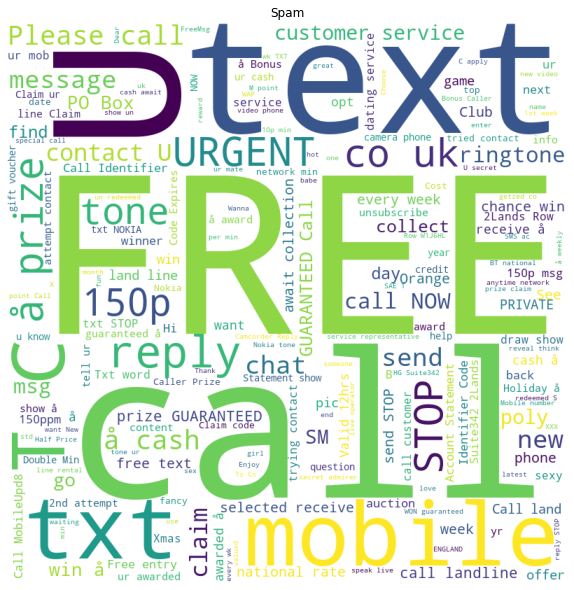

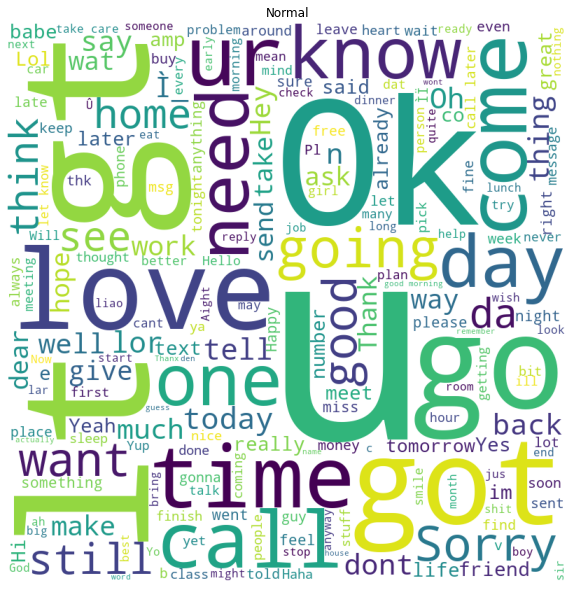

In [78]:
spam = ""
for i in df.loc[np.logical_and(df.text.notnull(), df.label == "spam")].text:
    spam += i + " "

ham = ""
for i in df.loc[np.logical_and(df.text.notnull(), df.label == "normal")].text:
    ham += i + " "

cloud_spam = wordcloud.WordCloud(width = 800, height = 800,
    background_color ='white',
    min_font_size = 10).generate(spam)

cloud_ham = wordcloud.WordCloud(width = 800, height = 800,
    background_color ='white',
    min_font_size = 10).generate(ham)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud_spam)
plt.title("Spam")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud_ham)
plt.title("Normal")
plt.axis("off")
plt.tight_layout(pad = 0)